In [1]:
## for each masks, check the overlaps with the staining stacks, calculate the histogram 
## and save this file for the analysis

import time
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import statistics
from scipy import stats
from numba import njit
import pickle
import json
import util as ut




In [2]:
@njit(fastmath=True)
def fast_cal(mask, stacks):
    """
    Generate the list of voxels from the staining stack where intensity is greater than zero for the given region 
    arguments:
        mask: region stack  
        stacks: gene expression stack
    returns:
        mask_list: list of voxels with value
    """  
    mask_list = []
    for i in range(len(mask)):
        for j in range(len(mask[i])):
            for k in range(len(mask[i][j])):
                if mask[i][j][k] == 0:
                    pass
                else:
                    mask_list.append(stacks[i][j][k])
    return mask_list

def calculate_histogram(mask, stacks, name):
    """
    Compute the histogram of staining stack in the region
    arguments:
        mask: region stack  
        stacks: gene expression stack
        name: name of the region
    returns:
        densitys: histogram density
    """  
    mask = mask.astype('float') 
    mask_list = fast_cal(mask, stacks)             
    densitys, bin_edges = np.histogram(mask_list, bins=256, range=(0,255), density=False )
    plt.plot(np.arange(0,256,1), densitys)
    plt.title("mask is %s" % name)
    plt.show()
    return densitys

def compute_densities(regions,regions_folder,save_folder, staining_name, specie, staining_stack_url):
    """
    Compute the staining expression density across regions and store it as pickle data  
    arguments:
        regions: list of regions 
        regions_folder: folder containing regions tiff stacks 
        save_folder: folder for saving density data
        staining_name: name of the staining
        specie: model organism
        staining_stack_url: staining stack url 
    returns:
        
    """
    staining_stack = tifffile.imread(staining_stack_url)
    distribution_data_set = []
    for i, name in enumerate(regions):
        print(i, name)
        m_mask = tifffile.imread(r"%s/%s.tif" % (regions_folder, name))
        densitys = calculate_histogram(mask=m_mask, stacks=staining_stack, name=name)
        d = {"region_name": name,
             "density_plt": densitys
            }
        distribution_data_set.append(d)
        
    filename = r"%s/%s_distribution_%s_new.pkl" % (save_folder, staining_name, specie)
    ut.write_pickle(distribution_data_set, filename)

In [12]:
import matplotlib.gridspec as gridspec

def add_element(lists, max_value):
    listss =  ([0] + np.array(lists).tolist() + [0])/max_value
    return listss


def get_number_ave_thres(distribution, max_threshold, bottom_threshold, top_threshold):
    """
    Compute the normalized average value in the range. Range is precomputed in such a way 
    that top 1% of the staining pixels are selected across the stack
    arguments:
        distribution: histogram 
        max_threshold: max intensity in the staining stack
        bottom_threshold: min value of the selected range
        top_threshold: max value of the selected range
    returns:
        ave_valu: average intensity value
    """ 
    new_dis = []
    xrange = np.arange(0,256,1)
    for i in range(len(xrange)):
        if i < bottom_threshold:
            new_dis.append(0)
        else:
            if i > top_threshold:
                new_dis.append(0)
            else:
                new_dis.append(distribution[i])
               
    ave_valu = np.dot(new_dis, xrange)/(np.sum(distribution)*max_threshold)
         
    return ave_valu


def manhattan_plots(precomputed_threshold_file, regions, colors, model_organism_list, staining_names_list, save_folder):
    """
    Manhattan plot
    arguments:
        precomputed_threshold_file: histogram 
        regions: list of regions 
        colors: colors for different model organisms
        model_organism_list: list of model organisms
        staining_names_list: list of staining
        save_folder: folder for storing plots
    returns:
        
    """ 
    threhold_values_map={}
    x = np.arange(0, len(regions)+1, 1) 
    xs =  x.tolist() + [len(regions)]
    threhold_values_list=ut.read_json(precomputed_threshold_file)
    for val_data in threhold_values_list:
        item_name=val_data['name']
        threhold_values_map[item_name]=val_data
    fig, axs = plt.subplots(len(staining_names_list), 2, figsize=(10, len(staining_names_list)*2))
    axs = axs.flat
    for list_i, list_gene_name in enumerate(staining_names_list):
        threshold_current=threhold_values_map[list_gene_name]
        bottom_list=threshold_current['lower_threshold']
        top_list=threshold_current['upper_threshold']
        for fish_i, fish_name  in enumerate(model_organism_list):
            # make figure subplot
            top_threshold=top_list[fish_i]
            bottom_threshold=bottom_list[fish_i]
            pickle_file_name='%s/%s_distribution_%s_new.pkl' % (save_folder, list_gene_name, fish_name)
            # read pickle
            distribution_map={}
            distribution_data=ut.read_pickle(pickle_file_name)
            for dist_data in distribution_data:
                reg_name=dist_data["region_name"]
                distribution_map[reg_name]=dist_data["density_plt"]
           
        
            ave_vals, top_med_vals = [],[]
            for i, name in enumerate(regions):
                if name in distribution_map:
                    regionname = name
                    data = distribution_map[name]
                    ave_val = get_number_ave_thres(distribution=data, max_threshold=top_threshold,
                                           bottom_threshold=bottom_threshold, top_threshold=top_threshold)
                else:
                    ave_val=0.0
                ave_vals.append(ave_val)

            max_value = max(ave_vals)
            ave_vals_MP = add_element(ave_vals, max_value)

            axs[2*list_i+0].step(xs, ave_vals_MP, color=colors[fish_i], alpha=0.7)
            axs[2*list_i+0].set_title("%s, ave" % staining_names_list[list_i])
            
    plt.tight_layout()
    plt.savefig("%s/manhattan_plot_test_thresholded_%s.svg" % (save_folder, list_gene_name))
    plt.show()
    

In [3]:
def test_compute_densities():
    specie="medaka"
    regions_folder="//final_misc_20-08-23\\tiff_misc_masks\\"
    m_folder = "final_data\\medaka"
    staining_stack_url=r"%s/MedakaRef_oxt_old_AND_DUP.tif" % m_folder
    save_folder="new_pkl_9_11_2024\\pickle_all_MECE_regions\\original\\"
    staining_name = "5HT_AND_BLEACHED_2_newOrder_MECE"
    mask_file="mece_masks.json"
    all_masks=ut.read_json(mask_file)
    mini_masks=all_masks['mini_masks']
    macro_masks=all_masks['macro_masks']
    regions=mini_masks+macro_masks
    print(macro_masks)
    compute_densities(regions,regions_folder,save_folder, staining_name, specie, staining_stack_url)


['Telencephalon', 'Diencephalon', 'Midbrain', 'Hindbrain', 'Spinal Cord', 'Ganglia']


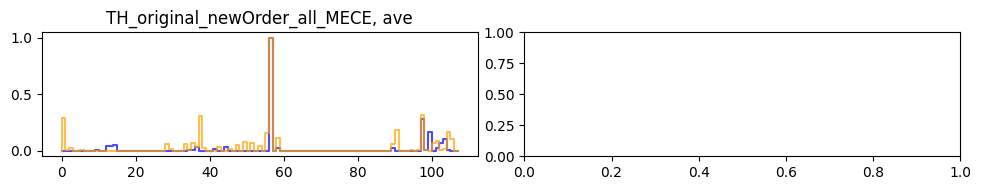

In [13]:
## make a figure for showing the Manhattan plot 
def test_ploting():
    staining_names_list = ["TH_original_newOrder_all_MECE"]
    model_organism_list = ["zebrafish", "medaka"]
    save_folder="new_pkl_9_11_2024\\pickle_all_MECE_regions\\original\\"
    precomputed_threshold_file="precomputed_thresholds_original.json"
    colors=["blue", "orange"]
    mask_file="mece_masks.json"
    all_masks=ut.read_json(mask_file)
    regions=all_masks['mini_masks']
    manhattan_plots(precomputed_threshold_file, regions, colors, model_organism_list, staining_names_list, save_folder)
    
test_ploting()